# Final Project EDA

## 주제: 항생제 감수성 예측 (내성)


- Preprocess, EDA 수행


```
Introduction

응급 환자에게 있어서, 항생제 감수성 여부는 중요한 요소이다.
응급한 상황에서 순서대로 항생제 1차, 2차, 3차를 투여하기에는 위험 부담이 크다. 감수성 여부를 따지지않고 높은 차수의 항생제를 투여하면,
지역 항생제 감수성이 만연하게 될 것이다.또한 3차 항생제의 부작용은 크기에 주의가 필요하다.

그래서, 환자의 감수성을 예측하는 것이 중요하다.
환자의 감수성에 맞춰 1차,2차 항생제를 투여하고,  3차 항생제를 투여하지않는다면 많은 부담을 줄일 수 있을 것이다. 그리고 응급환자에게 있어서 매우 효율적일 것이다.

항생제중 ciprofloxacin(CIP) 감수성 여부가 target이다. (0 : 감수성 , 1 : 내성)
CIP를 치료로 이용하는 병균 감염에는 뼈 및 관절염, 복강내 전염, 특정한 종류의 장염, 호흡기 감염, 피부 감염, 장티푸스, 요로감염증 등이 포함된다.

알려진 주요 가설은 다른 병원에 오래 있거나 고령, 침상 환자들은 지속적으로 항생제를 투여해서, 감수성이 있을것이란 것이다.

 

```

- 과제의 목표
- 여러가지 다변량 분석 방법을 수행하고 결과들을 비교해본다.
    - PCA + MCA를 통해 수치형 범주형 변수를 나눠서 분석
    - PCA만을 이용해 범주형,수치형 모두 분석 
    - 둘간의 결과 비교
    - Factor analysis
- 다변량 분석결과를 통해 변수 변환을 거쳐서 분류 분석을 실시한다.

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

import scipy.stats as stats # qqplot에 사용
import prince #MCA

In [74]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from statsmodels.graphics.mosaicplot import mosaic

plt.style.use("ggplot")


In [75]:
#분석 관련
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from statsmodels.formula.api import ols
from factor_analyzer import FactorAnalyzer

## 변수 설명




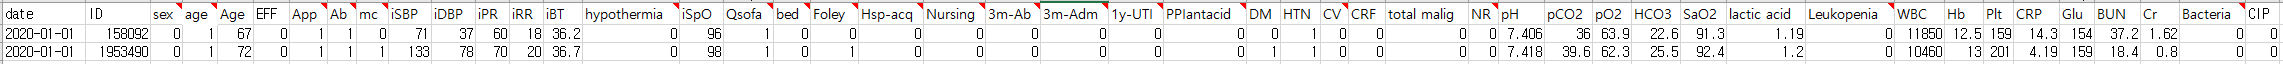

In [76]:
X = pd.read_excel("../data/CIP_data.xlsx")
print(X.shape)
X.head()

(550, 47)


,date,ID,sex,age,Age,EFF,App,Ab,mc,iSBP,...,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria,CIP
0,2020-01-01,158092,0,1,67,0,1.0,1.0,0,71,...,0,11850,12.5,159,14.30,154,37.2,1.62,0,0
1,2020-01-01,1953490,0,1,72,0,1.0,1.0,1,133,...,0,10460,13.0,201,4.19,159,18.4,0.80,0,0
2,2020-01-01,1953526,0,1,74,0,1.0,1.0,0,172,...,0,8430,12.7,183,9.24,269,13.0,0.70,0,0
3,2020-01-01,1260373,1,1,78,0,1.0,2.0,0,166,...,0,5740,11.9,152,4.59,138,29.5,1.73,0,1
4,2020-01-02,1842207,0,0,48,0,1.0,1.0,0,122,...,0,10530,12.3,207,0.18,109,11.5,0.97,0,0


In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         550 non-null    object 
 1   ID           550 non-null    int64  
 2   sex          550 non-null    int64  
 3   age          550 non-null    int64  
 4   Age          550 non-null    int64  
 5   EFF          550 non-null    int64  
 6   App          361 non-null    float64
 7   Ab           546 non-null    float64
 8   mc           550 non-null    int64  
 9   iSBP         550 non-null    int64  
 10  iDBP         550 non-null    int64  
 11  iPR          550 non-null    int64  
 12  iRR          550 non-null    int64  
 13  iBT          550 non-null    float64
 14  hypothermia  550 non-null    int64  
 15  iSpO         530 non-null    float64
 16  Qsofa        550 non-null    int64  
 17  bed          550 non-null    int64  
 18  Foley        550 non-null    int64  
 19  Hsp-acq 

```
(date형) date : 검사 날짜. (제거)
(수치) id: (제거)
(범주형) sex : 성별 [0:여,1:남 ]
(범주형,변수가공) age : 65세 [전:0 후:1] (분포를 보고 다시 결정)
(수치형) Age : 나이 
(범주형) EFF : Effectiveness. 감수성 여부를 떠나서 효과가 있었던 사람. (삭제해도되는 것.)
(범주형) App : 응급실에서 적절한 항생제를 사용했는지 여부. (제거 예정. 차후 결과 비교에 사용) (Ab 이용)
(범주형) Ab :  응급실에서 어떤 항생제를 투여했는지 여부, (0:CIP ,1:CTX ,2:PT ,3:Maxipime , 4 :no) (제거 예정)
(범주형) mc :  환자 의식이 변화된 정도. mental change. (없으면0 생기면 1) (제거해야할까. qSofa에 사용.)
(수치형) iSBP : 침습적 혈압 측정. invasive blood pressure 
(수치형) iDBP : 침습적 이완기 혈압 측정. invasive Diastolic  blood pressure
(수치형) iPR : 맥박 측정 pulse rate
(수치형) iRR :  침습적 호흡 측정. Respiratory rate
(수치형) iBT :  침습적 체온 측정. invasive Body Temperature
(범주형,변수가공) hypothermia : 36도 미만 저체온 여부 (분포 보고 다시 결정.)
(수치형) iSpO :  산소포화도. Peripheral oxygen saturation
(범주형,label encoding) Qsofa : 의식 변화, 수축기 혈압, 호흡수를 기준으로 점수를 내 사망률 위험 추정 점수 . Quick Sequential Organ Failure Assessment 
(범주형) **bed : 침상환자 여부
(범주형) Foley : 도뇨관의 종류. (Urinary catheter/Cystostomy)
(범주형) **Hsp-acq : 최근 수술 및 입원 여부  hospital acquired (1. 2일 이상 입원후 전원 2. 30일내 수술력 3. 퇴원한지 3일내)
(범주형) Nursing : 요양원,가정 간호 여부
(범주형) 3m-Ab : 3달 이내 항생제 복용여부 
(범주형) 3m-Adm : 최근 3달내 입원 여부
(범주형) **1y-UTI : 1년내 요로감염이력
(범주형) PPlantacid : 위식도 역류질환 제산제 사용여부
(범주형) DM : 당뇨병 여부. diabetes mellitus 
(범주형) HTN : 고혈압 여부. hypertension
(범주형) CV : 혈압 제외 심장질환 여부 (CAOD, HCMP, CHF)
(범주형) CRF  : 만성신부전 여부 Chronic Renal Failure
(범주형) total malig :  악성 종양 여부
(범주형) NR : neurodegenerative disease 여부 :CVA, Dementia,CP 포함.
(수치형) pH : 산성도
(수치형) pCO2 : 이산화탄소 분압
(수치형) pO2 :  산소 분압
(수치형) HCO3 : 탄산수소염
(수치형) SaO2 :동맥혈 산소포화도
(수치형) latic acid : 젖산
(범주형) Leukopenia : 백혈구 감소증 여부. WBC<4000 (domain내용으로 사용예정.)
(수치형) WBC : 백혈구 수
(수치형) Hb : Hemoglobin 헤모글로빈
(수치형) Plt : Pulse rate 맥박수
(수치형) CRP : C 반응성 단백질 (페렴 구균에 반응)
(수치형) Glu : Glucose 글루테인
(수치형) BUN : Blood urea nitrogen 혈액 요소성 질소.
(수치형) Cr  : Creatinine
(범주형) Bacteria : 박테리아 감염 여부. 어떤 박테리아냐에 따라 (ground-truth와 같이 나오는 자료이기에 사용할 수 없다.)

-- target
(범주형 TARGET) CIP : CIP 감수성 여부. (0: 감수성, 1 : 내성) (소변검사 실시. ground truth)


** 은 알려진 주요 변수를 의미한다.
label encoding을 제외한 모든 범주형 자료는 dummy 형태이다.

```

---

목표

- PCA + MCA를 통해 수치형 범주형 변수를 나눠서 분석
- PCA만을 이용해 모든 컬럼 분석
- 두 방법의 결과 비교
- Factor analysis
- 분류 분석


---

참고자료

https://syj9700.tistory.com/44

https://dschloe.github.io/python/python_edu/05_statistics/chapter_5_2_positioning_analysis_2/

CA를 통해 범주들 간에 관계를 살펴볼 수도 있다.


In [78]:
X[['sex','age','EFF','App','Ab','mc','hypothermia','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','Bacteria','DM','HTN']] =X[['sex','age','EFF','App','Ab','mc','hypothermia','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','Bacteria','DM','HTN']].astype('category') 

In [79]:
X.describe()

,ID,Age,iSBP,iDBP,iPR,iRR,iBT,iSpO,pH,pCO2,...,SaO2,lactic acid,WBC,Hb,Plt,CRP,Glu,BUN,Cr,CIP
count,5.500000e+02,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,530.000000,477.000000,477.000000,...,521.000000,516.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,1.135138e+06,72.130909,127.550909,72.983636,97.938182,20.254545,38.547273,95.632075,38.688985,33.506080,...,96.192898,2.652539,12006.927273,11.784727,209.623636,12.125800,165.023636,28.350727,1.347418,0.465455
std,7.118698e+05,15.857320,30.484792,17.838011,22.045734,3.807854,14.990417,4.687847,482.001177,7.032382,...,38.449239,6.337611,6495.844084,8.963564,100.975272,8.980668,94.303763,44.084563,1.319023,0.499259
min,6.110000e+02,18.000000,46.000000,32.000000,32.000000,12.000000,25.600000,36.000000,6.905000,12.000000,...,31.100000,0.200000,360.000000,5.400000,10.000000,0.040000,28.000000,4.500000,0.320000,0.000000
25%,4.367282e+05,65.000000,106.000000,60.000000,84.000000,18.000000,37.000000,95.000000,7.420000,29.700000,...,93.200000,1.140000,7805.000000,10.100000,144.250000,5.422500,111.000000,13.100000,0.720000,0.000000
50%,1.197335e+06,76.000000,126.500000,72.000000,98.000000,20.000000,38.000000,97.000000,7.452000,33.300000,...,95.500000,1.660000,11150.000000,11.500000,193.500000,10.465000,139.000000,20.600000,0.970000,0.000000
75%,1.910642e+06,83.000000,150.000000,83.000000,113.000000,22.000000,38.900000,98.000000,7.480000,37.200000,...,97.200000,2.740000,14807.500000,12.700000,254.750000,16.880000,183.750000,33.375000,1.520000,1.000000
max,2.015722e+06,102.000000,208.000000,138.000000,182.000000,50.000000,388.000000,100.000000,7482.000000,83.800000,...,964.000000,100.000000,54280.000000,216.000000,831.000000,52.610000,951.000000,939.400000,20.300000,1.000000


## 데이터 제거

- [date , id ,Age , EEF, App, Ab , hypothermia , bacteria] 컬럼 제거

In [80]:
X.drop(['date','ID','age','EFF','App','Ab','hypothermia','Bacteria'],axis=1,inplace=True)

# 데이터 확인

In [81]:
X

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,lactic acid,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,CIP
0,0,67,0,71,37,60,18,36.2,96.0,1,...,1.19,0,11850,12.5,159,14.30,154,37.2,1.62,0
1,0,72,1,133,78,70,20,36.7,98.0,1,...,1.20,0,10460,13.0,201,4.19,159,18.4,0.80,0
2,0,74,0,172,71,117,24,39.5,95.0,1,...,2.32,0,8430,12.7,183,9.24,269,13.0,0.70,0
3,1,78,0,166,78,93,28,38.8,85.0,1,...,1.34,0,5740,11.9,152,4.59,138,29.5,1.73,1
4,0,48,0,122,81,83,16,36.7,98.0,0,...,0.50,0,10530,12.3,207,0.18,109,11.5,0.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0,74,0,135,76,93,18,37.3,100.0,0,...,1.30,0,20770,11.9,276,20.72,157,11.4,0.55,0
546,1,83,0,167,85,89,32,39.2,95.0,1,...,3.59,0,7850,11.1,84,4.40,112,16.5,1.51,1
547,0,77,0,81,49,117,20,38.3,95.0,1,...,0.67,0,10600,10.0,296,7.74,141,21.2,0.72,1
548,0,86,0,177,79,69,20,37.5,99.0,0,...,1.17,0,6560,7.3,209,0.84,115,34.0,2.68,1


In [82]:
#차원 확인
print("all data: ",X.shape)

all data:  (550, 39)


In [83]:
print("yes : ",sum(X['CIP']==1))
print("no : ",sum(X['CIP']==0))

yes :  256
no :  294


Label이 균형있게 분포되어있다.

## 결측치 확인

In [84]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        col_type = dataframe[col].dtype
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: ({col_type}) {col} 입니다. 해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(X)

결측치가 있는 컬럼은: (float64) iSpO 입니다. 해당 컬럼에 총 20 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 3m-Ab 입니다. 해당 컬럼에 총 7 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 3m-Adm 입니다. 해당 컬럼에 총 6 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 1y-UTI 입니다. 해당 컬럼에 총 7 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) PPIantacid 입니다. 해당 컬럼에 총 7 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) CV 입니다. 해당 컬럼에 총 1 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pH 입니다. 해당 컬럼에 총 73 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pCO2 입니다. 해당 컬럼에 총 73 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pO2 입니다. 해당 컬럼에 총 73 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) HCO3 입니다. 해당 컬럼에 총 73 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) SaO2 입니다. 해당 컬럼에 총 29 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) lactic acid 입니다. 해당 컬럼에 총 34 개의 결측치가 존재합니다.


### 결측치 처리 1 - 모두 제거

자료들간에 상관계수가 낮아서, 예측이 어려울 것이라 생각해 모두 제거.


In [85]:

X.dropna(axis=0,inplace=True)



print("전체 데이터셋 사이즈 : ",X.shape)

전체 데이터셋 사이즈 :  (468, 39)


### 결측치 처리 2 - knn regressor

많은 결측치가 수치형 자료에 존재한다. 수치형 자료의 결측치 수가 10% 이상이기에, 모두 제거할 수는 없다고 생각된다.

범주형 자료들은 예측할 수 없기에, 모두 제거한다.


In [86]:
#x_train=x_train[x_train[['3m-Ab','3m-Adm','1y-UTI','PPIantacid','CV']].isna().sum(axis=1)==0]
#print(x_train.shape)

In [87]:
#not_in=list(set(x_train.corr().columns) - set(['iSpO','pH','pCO2','pO2','HCO3','SaO2','lactic acid']))
#x_train.corr().loc[['iSpO','pH','pCO2','pO2','HCO3','SaO2','lactic acid'],not_in]

- 수치형 변수 결측치 처리방법.

수치형 자료들은, 상관 계수를 보고 높은 컬럼들을 선정해서 회귀식을 세운다.

In [88]:
#x_train[x_train[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)>0]

In [89]:
#X[X[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)==0]
#missing_col = check_missing_col(X[X[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)==0])

In [90]:
#X.columns

## 데이터 분할

In [91]:
Y=X['CIP']
X.drop(['CIP'],axis=1,inplace=True)

In [92]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [93]:

print('train set : ',x_train.shape)
print('test set : ', x_test.shape)

train set :  (374, 38)
test set :  (94, 38)


In [94]:
print("train yes : ",sum(y_train==1))
print("train no : ",sum(y_train==0))

train yes :  188
train no :  186


# Feature Importance 확인

- 범주형 자료에서는 독립성 검정을 통해서, 자료와 target 독립 여부, p-value를 확인한다.
- 수치형 자료에서는 ks 검정을 통해서, p-value, 자료와 target 독립 여부 확인한다.



In [95]:
def Get_feature_importance(data,label):
    result_df = pd.DataFrame(columns=['VarNum','Feature','type','test','p_value'])
    VarNum=[]
    Feature=[]
    feat_type=[]
    test=[]
    p_value=[]
    for idx,col in enumerate(data.columns):
        col_type = data[col].dtype
        feat_type.append(col_type)
        Feature.append(col)
        VarNum.append(idx)

        if col_type.name =='category':
            feat_crosstab=pd.crosstab(data[col],label)
            feat_crosstab_res=chi2_contingency(feat_crosstab)
            test_res = '기각' if feat_crosstab_res[1] < 0.05  else '채택'
            test.append(test_res)
            p_value.append(feat_crosstab_res[1])
        else:
            ks_res=kstest(x_train[y_train==1][col],x_train[y_train==0][col])
            test_res = '기각' if ks_res[1] < 0.05  else '채택'
            test.append(test_res)
            p_value.append(ks_res[1])
    result_df['VarNum'] = VarNum
    result_df['Feature'] = Feature
    result_df['type'] = feat_type
    result_df['test'] = test
    result_df['p_value'] = p_value
    return result_df

#missing_col = check_missing_col(x_train)
result_df=Get_feature_importance(x_train,y_train)
result_df.to_excel('./result_df.xlsx',index=False)
result_df


,VarNum,Feature,type,test,p_value
0,0,sex,category,기각,1.830329e-02
1,1,Age,int64,채택,2.654917e-01
2,2,mc,category,채택,5.508948e-02
3,3,iSBP,int64,채택,3.512156e-01
4,4,iDBP,int64,기각,2.370587e-02
5,5,iPR,int64,채택,4.595754e-01
6,6,iRR,int64,채택,7.519365e-01
7,7,iBT,float64,기각,8.798633e-03
8,8,iSpO,float64,채택,5.807386e-02
9,9,Qsofa,category,채택,1.016029e-01


검정 결과 유의한 자료로는

- 범주형 :  sex,mc,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
- 수치형 :  Age,iDBP,iBT,pCO2,SaO2,Hb,Plt

총 38개의 feature들 중 19개만 유의하다고 볼 수 있다.

# 수치형 자료 PCA


자료의수는 적고, 컬럼의 수는 많기에 적절한 선형결합을 찾아서 분류에 활용하면 좋겠다고 생각해서 PCA 수행.



In [96]:
x_bar = x_train.mean(axis=0,numeric_only=True)
#x_s = x_train.cov()
print('표본 평균 :\n',x_bar)

표본 평균 :
 Age               73.850267
iSBP             126.991979
iDBP              72.812834
iPR               97.510695
iRR               20.451872
iBT               38.757487
iSpO              95.409091
pH                47.296425
pCO2              33.472460
pO2               79.734225
HCO3              23.717914
SaO2              96.681016
lactic acid        2.243503
WBC            12286.604278
Hb                11.807487
Plt              208.045455
CRP               13.007406
Glu              165.847594
BUN               30.497326
Cr                 1.430267
dtype: float64


변수들간에 scale 차이가 크기에, 상관계수 행렬을 이용해서 pca

In [97]:
#sns.pairplot(x_train.select_dtypes(include=np.number))

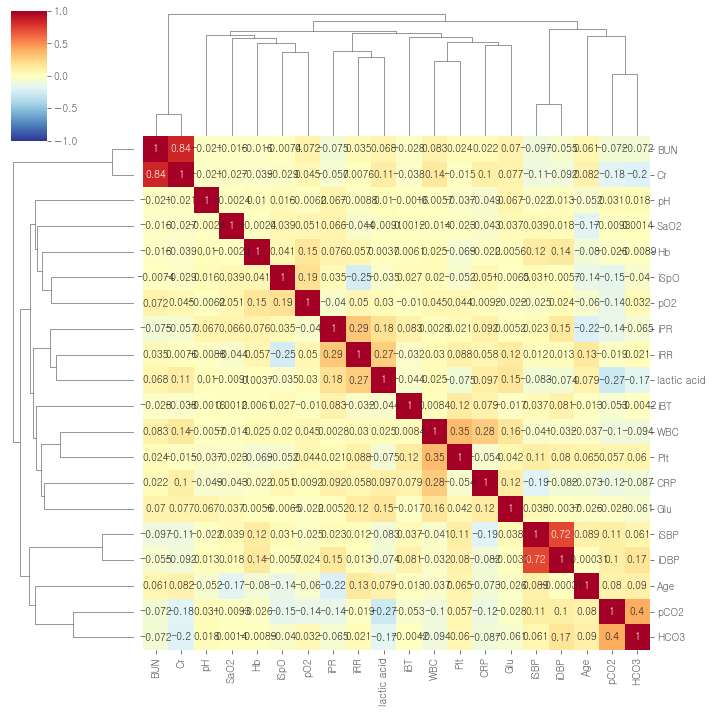

In [98]:
x_R = x_train.corr()

sns.clustermap(x_R, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

동시에 여러 변수들이 상관관계를 띄는것이 아닌, 몇몇 쌍들끼리 상관 관계를 띄는것으로 관측된다.

대부분의 변수들이 상관성이 떨어지는것으로 관측된다.

## 모든 수치형 자료 PCA

- 모든 컬럼을 사용하여 pca  수행

2개의 주성분을 사용하여, 분산 설명 비율:  0.20664526102339123
PC 1,2 Directions :
 [[ 0.02022468  0.089376    0.37929106  0.26731481 -0.07086067 -0.38115412
   0.19902822 -0.13483788  0.02968112 -0.13635863 -0.24404321  0.09220608
   0.27972181 -0.3482204  -0.37941131 -0.14555691 -0.22203593  0.24734546
   0.06396196  0.03800972]
 [ 0.34298265 -0.41215007  0.25477654 -0.18676868 -0.11813224 -0.17452205
  -0.14686027 -0.1916177  -0.06392039  0.0392647  -0.02275271 -0.05609049
   0.07432291  0.06596852 -0.03783209  0.09844396  0.10052022 -0.06895386
  -0.67611511  0.08788037]]


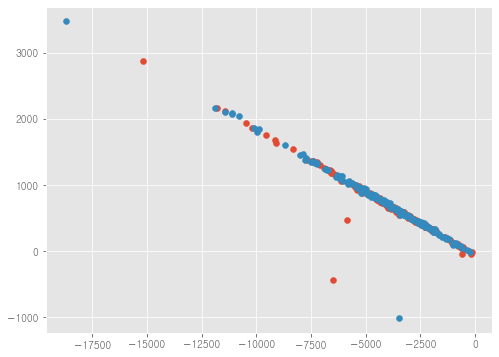

In [99]:
x_R = x_train.corr()
eig_vals,eig_vecs =np.linalg.eig(x_R)

idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:,idx]


print("2개의 주성분을 사용하여, 분산 설명 비율: ", np.sum(eig_vals[0:2])/np.sum(eig_vals))
print('PC 1,2 Directions :\n',eig_vecs[0:2])

PCA=x_train.select_dtypes(include=np.number).dot(eig_vecs[0:2].T)
#print('PC 1,2 :\n',PCA)

PCA.columns=['PCA1','PCA2']

fig =plt.figure(figsize=(8,6))
sensibility = PCA[y_train==0] # 
tolerance = PCA[y_train==1] #

plt.scatter(sensibility.iloc[:,0],sensibility.iloc[:,1],label='감수성')
plt.scatter(tolerance.iloc[:,0],tolerance.iloc[:,1],label='내성')

#plt.scatter(PCA.iloc[:,0],PCA.iloc[:,1])
plt.show()

1,2 PC로는 분류를 못하는 상황이다.

1개 포함시 누적 비율 : 11.7967%
2개 포함시 누적 비율 : 20.6645%
3개 포함시 누적 비율 : 29.2586%
4개 포함시 누적 비율 : 36.9754%
5개 포함시 누적 비율 : 44.0212%
6개 포함시 누적 비율 : 49.8228%
7개 포함시 누적 비율 : 55.5267%
8개 포함시 누적 비율 : 60.8577%
9개 포함시 누적 비율 : 65.9522%
10개 포함시 누적 비율 : 70.9253%
11개 포함시 누적 비율 : 75.6187%
12개 포함시 누적 비율 : 80.0414%
13개 포함시 누적 비율 : 83.9252%
14개 포함시 누적 비율 : 87.5087%
15개 포함시 누적 비율 : 90.6910%
16개 포함시 누적 비율 : 93.4004%
17개 포함시 누적 비율 : 95.8026%
18개 포함시 누적 비율 : 98.1445%
19개 포함시 누적 비율 : 99.3075%
20개 포함시 누적 비율 : 100.0000%


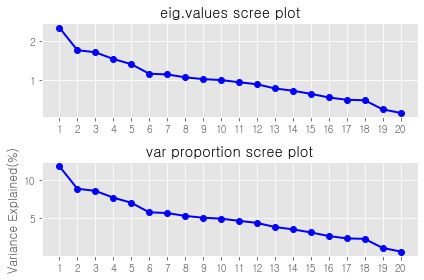

In [100]:
cur_var = []

for i in range(20):
    cur_var.append( np.sum(eig_vals[i:i+1])*100/np.sum(eig_vals) ) 
    print("{}개 포함시 누적 비율 : {:.4f}%".format(i+1,np.sum(eig_vals[0:i+1])*100/np.sum(eig_vals)))


    
plt.subplot(2,1,1)
plt.plot(np.arange(20)+1,eig_vals, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('eig.values scree plot')

plt.subplot(2,1,2)
plt.plot(np.arange(20)+1,cur_var, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('var proportion scree plot')
plt.ylabel('Variance Explained(%)')

plt.tight_layout()
plt.show()

elbow는 2pc에서 관측되지만, 분산의 설명비율이 매우 떨어진다.

결과적으로 수치형 변수들간에 상관성은 떨어지는것으로 해석된다.

6번 pc까지만 기울기가 가파르다.

분석시에 12개 pc를 포함한다면, 80% 분산을 설명 할 수 있다.

## 12개 PC direction 시각화



In [101]:
df_cols = x_train.select_dtypes(include=np.number).columns
pc_frame = pd.DataFrame(columns=df_cols) 
pc_frame.loc['PC1']=eig_vecs[0]
pc_frame.loc['PC2']=eig_vecs[1]
pc_frame.loc['PC3']=eig_vecs[2]
pc_frame.loc['PC4']=eig_vecs[3]
pc_frame.loc['PC5']=eig_vecs[4]
pc_frame.loc['PC6']=eig_vecs[5]
pc_frame.loc['PC7']=eig_vecs[6]
pc_frame.loc['PC8']=eig_vecs[7]
pc_frame.loc['PC9']=eig_vecs[8]
pc_frame.loc['PC10']=eig_vecs[9]
pc_frame.loc['PC11']=eig_vecs[10]
pc_frame.loc['PC12']=eig_vecs[11]
pc_frame


,Age,iSBP,iDBP,iPR,iRR,iBT,iSpO,pH,pCO2,pO2,HCO3,SaO2,lactic acid,WBC,Hb,Plt,CRP,Glu,BUN,Cr
PC1,0.020225,0.089376,0.379291,0.267315,-0.070861,-0.381154,0.199028,-0.134838,0.029681,-0.136359,-0.244043,0.092206,0.279722,-0.348220,-0.379411,-0.145557,-0.222036,0.247345,0.063962,0.038010
PC2,0.342983,-0.412150,0.254777,-0.186769,-0.118132,-0.174522,-0.146860,-0.191618,-0.063920,0.039265,-0.022753,-0.056090,0.074323,0.065969,-0.037832,0.098444,0.100520,-0.068954,-0.676115,0.087880
PC3,0.331535,-0.456689,0.222469,-0.187763,-0.106924,-0.064084,-0.131054,-0.051073,0.089430,0.106712,-0.051734,-0.140986,0.145620,0.146014,0.117509,-0.041749,-0.030306,0.004602,0.674072,-0.078239
PC4,-0.030998,-0.405794,-0.265120,0.160945,-0.121112,0.176885,-0.151509,0.362759,0.093381,-0.022530,0.056499,-0.324553,-0.169796,-0.151766,-0.185248,-0.150763,-0.317415,0.439833,-0.124768,0.035153
PC5,-0.083169,-0.313573,0.064342,0.498229,-0.133405,0.132759,0.242022,0.171494,-0.058485,0.002825,-0.021191,-0.027472,-0.050850,0.116309,-0.376755,0.130481,0.484314,-0.310404,0.074806,-0.052482
PC6,0.033688,-0.140698,-0.044841,-0.060096,0.216916,-0.215875,-0.216758,0.471834,0.314294,-0.168180,-0.343777,0.554917,-0.067362,0.017004,0.069090,0.086861,0.176706,0.089621,-0.021545,-0.011597
PC7,-0.028591,-0.030876,-0.235557,-0.467619,0.063598,-0.084473,0.143987,-0.134312,0.110405,-0.122093,-0.332665,-0.318508,-0.276767,-0.433762,-0.263079,0.176132,0.192809,-0.150535,0.087528,-0.049323
PC8,0.020694,-0.028196,-0.070672,0.012312,-0.059327,0.383915,-0.122611,-0.232373,0.405700,-0.675434,0.109675,0.006111,0.355932,0.013867,-0.044092,0.019840,-0.005891,-0.104535,-0.023544,0.009251
PC9,0.332126,0.201527,0.256740,0.130487,0.114232,0.370170,0.009897,0.016227,0.117749,0.160218,-0.033225,-0.010960,-0.103559,-0.109467,-0.031731,0.687815,-0.087270,0.259360,0.017659,-0.054245
PC10,-0.075460,-0.126475,-0.061251,-0.281449,0.002744,0.066610,0.674061,0.079728,-0.097683,-0.159211,-0.188224,0.032897,0.117021,0.480515,-0.004116,0.122241,-0.155865,0.266568,-0.062317,-0.000991


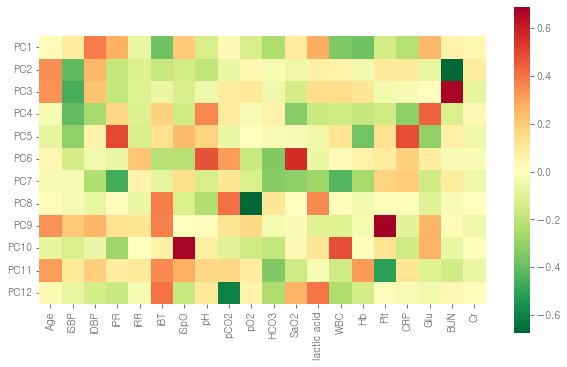

In [102]:

fig =plt.figure(figsize=(10,6))
ax = sns.heatmap(pc_frame,
                 cmap='RdYlGn_r',# cmap Color
                 annot=False,            # Value Text
                 square=True,
                )
#PCA1과 PCA2 모두 각자 다른 feature가 높다.

5pc 이하에서는 Age,iSBP,iDBP,iPR, BUN, Cr , latic acid,WBC,Hb,plt 의 분산 기여도가 크다.

6pc 이상에서는 pH,pCO2,PO2,HCO3가 기여도가 높다.

모든 변수들을 pca 하기보다는,  (AGE~ iPR + latic acid ~ Cr),(iRR ~ latic acid)로 나눠서 pca를 할 수도 있어 보인다.

정준상관분석을 통해, CORR이 높은 방향의 변수들만 따로 pca 할 수 있을것으로 생각.

## 유의한 변수 PCA

- 검정 결과 유의한 수치형 변수들을 활용한 PCA


In [103]:
x_trained_reduced = x_train[['Age','iDBP','iBT','pCO2','SaO2','Hb','Plt']].copy() 


2개의 주성분을 사용하여, 분산 설명 비율:  0.3518828351354953
PC 1,2 Directions :
 [[ 0.58359586 -0.27120497  0.15700746 -0.1591258  -0.19586306  0.62839187
   0.32039458]
 [ 0.19417669  0.64516903  0.27732376  0.0141358  -0.06292036  0.31984517
  -0.60223264]]


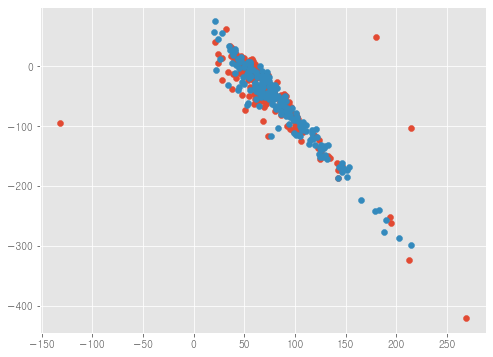

In [104]:
x_R = x_trained_reduced.corr()
eig_vals,eig_vecs =np.linalg.eig(x_R)

idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:,idx]


print("2개의 주성분을 사용하여, 분산 설명 비율: ", np.sum(eig_vals[0:2])/np.sum(eig_vals))
print('PC 1,2 Directions :\n',eig_vecs[0:2])

PCA=x_trained_reduced.select_dtypes(include=np.number).dot(eig_vecs[0:2].T)
#print('PC 1,2 :\n',PCA)

PCA.columns=['PCA1','PCA2']

fig =plt.figure(figsize=(8,6))
sensibility = PCA[y_train==0] # 
tolerance = PCA[y_train==1] #

plt.scatter(sensibility.iloc[:,0],sensibility.iloc[:,1],label='감수성')
plt.scatter(tolerance.iloc[:,0],tolerance.iloc[:,1],label='내성')

#plt.scatter(PCA.iloc[:,0],PCA.iloc[:,1])
plt.show()

2개의 주성분을 활용해 35%를 설명한다.

변수들간에 상관성이 적다는 것을 의미하며, 산점도를 통해 수치형 변수들 만으로 target을 설명하지 못함을 알 수 있다.

하지만, 모든 데이터를 썼을때 보다 비교적 잘 구분된 것 처럼 보인다. 

따라서, 유의한 수치형 변수들만 활용하는 것이 더 좋아보인다.



1개 포함시 누적 비율 : 17.9595%
2개 포함시 누적 비율 : 35.1883%
3개 포함시 누적 비율 : 50.7544%
4개 포함시 누적 비율 : 65.5124%
5개 포함시 누적 비율 : 77.4127%
6개 포함시 누적 비율 : 88.9422%
7개 포함시 누적 비율 : 100.0000%


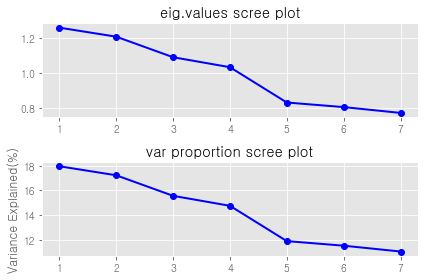

In [105]:
cur_var = []

for i in range(7):
    cur_var.append( np.sum(eig_vals[i:i+1])*100/np.sum(eig_vals) ) 
    print("{}개 포함시 누적 비율 : {:.4f}%".format(i+1,np.sum(eig_vals[0:i+1])*100/np.sum(eig_vals)))


    
plt.subplot(2,1,1)
plt.plot(np.arange(7)+1,eig_vals, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('eig.values scree plot')

plt.subplot(2,1,2)
plt.plot(np.arange(7)+1,cur_var, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('var proportion scree plot')
plt.ylabel('Variance Explained(%)')

plt.tight_layout()
plt.show()



In [106]:
df_cols = x_trained_reduced.select_dtypes(include=np.number).columns
pc_frame = pd.DataFrame(columns=df_cols) 
pc_frame.loc['PC1']=eig_vecs[0]
pc_frame.loc['PC2']=eig_vecs[1]
pc_frame.loc['PC3']=eig_vecs[2]
pc_frame.loc['PC4']=eig_vecs[3]
pc_frame.loc['PC5']=eig_vecs[4]
pc_frame.loc['PC6']=eig_vecs[5]
pc_frame.loc['PC7']=eig_vecs[6]

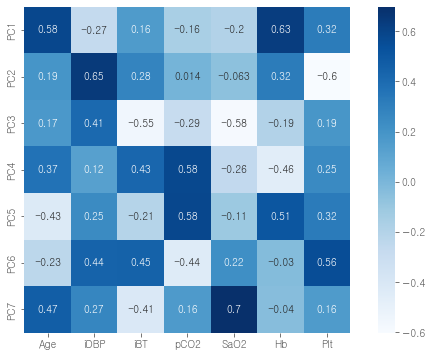

In [107]:

fig =plt.figure(figsize=(10,6))
ax = sns.heatmap(pc_frame,
                 cmap='Blues',# cmap Color
                 annot=True,            # Value Text
                 square=True,
                )
#PCA1과 PCA2 모두 각자 다른 feature가 높다.

pc1에서 iDBP,pCO2,SaO2 음의 계수를 가지며  / Age,iBT,헤모글로빈,Plt는, 양의 계수를 가진다. 

해석하면, 두 그룹이 corr의 같은 계수를 가질 것으로 생각할 수 있다.




# 유의한 모든 변수를 활용하여, PCA

- 범주형 자료를 포함하여 PCA 수행

In [108]:
x_trained_reduced = x_train[['Age','iDBP','iBT','pCO2','SaO2','Hb','Plt']].copy() 
x_trained_reduced_category=x_train[[ 'sex','mc','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].copy().astype('float64')


x_trained_reduced_all=pd.concat([x_trained_reduced,x_trained_reduced_category],axis=1)
x_trained_reduced_all

,Age,iDBP,iBT,pCO2,SaO2,Hb,Plt,sex,mc,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
81,73,65,35.3,36.7,93.8,10.4,164,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
257,83,59,36.6,45.0,96.6,7.7,285,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
221,65,95,39.6,28.1,96.0,12.2,254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21,69,77,36.9,29.0,97.3,10.5,90,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
170,57,79,39.1,31.3,92.8,11.5,298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,75,69,39.0,34.8,96.8,12.9,238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27,75,62,38.6,30.6,91.7,12.0,337,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
279,81,62,36.7,38.6,85.1,9.8,386,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
11,83,62,37.8,26.7,99.6,8.0,533,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


2개의 주성분을 사용하여, 분산 설명 비율:  0.26275116521702196
PC 1,2 Directions :
 [[-0.22617974  0.25348345  0.3953523   0.29457066  0.12747487 -0.05275475
  -0.07375566  0.05871743 -0.03557315 -0.04300373 -0.19294361  0.08197963
  -0.23006295 -0.03216873 -0.46480173 -0.53826062 -0.03156136 -0.07213908
   0.02452026]
 [ 0.03765038 -0.07455049 -0.37594499  0.4374707   0.32344377 -0.27041512
   0.04689517  0.12437052 -0.1564943  -0.09176378 -0.30737477  0.30698384
  -0.21582145  0.33029825  0.03357111  0.22734723  0.18565473  0.01743984
  -0.00334727]]


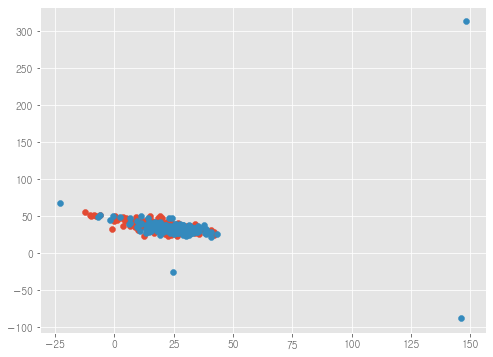

In [109]:
x_R = x_trained_reduced_all.corr()
eig_vals,eig_vecs =np.linalg.eig(x_R)

idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:,idx]


print("2개의 주성분을 사용하여, 분산 설명 비율: ", np.sum(eig_vals[0:2])/np.sum(eig_vals))
print('PC 1,2 Directions :\n',eig_vecs[0:2])

PCA=x_trained_reduced_all.select_dtypes(include=np.number).dot(eig_vecs[0:2].T)
#print('PC 1,2 :\n',PCA)

PCA.columns=['PCA1','PCA2']

fig =plt.figure(figsize=(8,6))
sensibility = PCA[y_train==1] # 
tolerance = PCA[y_train==0] #

plt.scatter(sensibility.iloc[:,0],sensibility.iloc[:,1],label='감수성')
plt.scatter(tolerance.iloc[:,0],tolerance.iloc[:,1],label='내성')

#plt.scatter(PCA.iloc[:,0],PCA.iloc[:,1])
plt.show()

1개 포함시 누적 비율 : 17.1039%
2개 포함시 누적 비율 : 26.2751%
3개 포함시 누적 비율 : 33.1316%
4개 포함시 누적 비율 : 39.6868%
5개 포함시 누적 비율 : 45.9655%
6개 포함시 누적 비율 : 51.9788%
7개 포함시 누적 비율 : 57.5607%
8개 포함시 누적 비율 : 62.7283%
9개 포함시 누적 비율 : 67.7241%
10개 포함시 누적 비율 : 72.6118%
11개 포함시 누적 비율 : 76.9665%
12개 포함시 누적 비율 : 80.9415%
13개 포함시 누적 비율 : 84.8477%
14개 포함시 누적 비율 : 88.5988%
15개 포함시 누적 비율 : 91.8418%
16개 포함시 누적 비율 : 94.8265%
17개 포함시 누적 비율 : 97.0437%
18개 포함시 누적 비율 : 98.6259%
19개 포함시 누적 비율 : 100.0000%


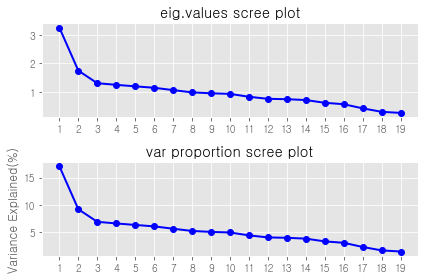

In [110]:
cur_var = []

for i in range(19):
    cur_var.append( np.sum(eig_vals[i:i+1])*100/np.sum(eig_vals) ) 
    print("{}개 포함시 누적 비율 : {:.4f}%".format(i+1,np.sum(eig_vals[0:i+1])*100/np.sum(eig_vals)))


    
plt.subplot(2,1,1)
plt.plot(np.arange(19)+1,eig_vals, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('eig.values scree plot')

plt.subplot(2,1,2)
plt.plot(np.arange(19)+1,cur_var, 'o-', linewidth=2, color='blue',)
plt.xticks(np.arange(1, len(eig_vals)+1, 1))
plt.title('var proportion scree plot')
plt.ylabel('Variance Explained(%)')

plt.tight_layout()
plt.show()



12개 PC를 포함해야 80%를 설명할 수 있다

In [111]:
df_cols = x_trained_reduced_all.columns
pc_frame = pd.DataFrame(columns=df_cols) 
pc_frame.loc['PC1']=eig_vecs[0]
pc_frame.loc['PC2']=eig_vecs[1]
pc_frame.loc['PC3']=eig_vecs[2]
pc_frame.loc['PC4']=eig_vecs[3]
pc_frame.loc['PC5']=eig_vecs[4]
pc_frame.loc['PC6']=eig_vecs[5]
pc_frame.loc['PC7']=eig_vecs[6]
pc_frame.loc['PC8']=eig_vecs[7]
pc_frame.loc['PC9']=eig_vecs[8]
pc_frame.loc['PC10']=eig_vecs[9]
pc_frame.loc['PC11']=eig_vecs[10]
pc_frame.loc['PC12']=eig_vecs[11]

In [112]:
eig_vecs[0]

array([-0.22617974,  0.25348345,  0.3953523 ,  0.29457066,  0.12747487,
       -0.05275475, -0.07375566,  0.05871743, -0.03557315, -0.04300373,
       -0.19294361,  0.08197963, -0.23006295, -0.03216873, -0.46480173,
       -0.53826062, -0.03156136, -0.07213908,  0.02452026])

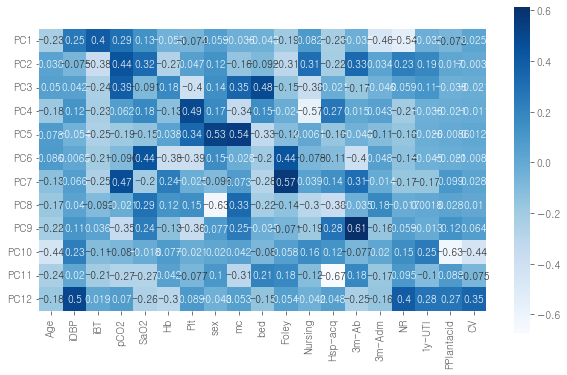

In [113]:

fig =plt.figure(figsize=(10,6))
ax = sns.heatmap(pc_frame,
                 cmap='Blues',# cmap Color
                 annot=True,            # Value Text
                 square=True,
                 
                )
#PCA1과 PCA2 모두 각자 다른 feature가 높다.

유의하게 해석되지 못한다.

PC1에서 Nursing과 bed 서로 다른 계수를 갖거나 등 생각했던것과 다른 값을 띈다.

# 유의한 수치형 자료 Factor Analysis

Factor Analysis는 잠재된 공통요인을 찾는 방법이다.

혈압 , 맥박, 호흡 , 혈중 농도들 간에 서로 공통된 요소가 있을 것이라 생각한다.

이를 통해 feature 요약이 될 것이라 생각함.

이전 PCA를 통해, PC5 까지 포함해야 77%를 설명할 수 있기에 5개의 Factor로 설정.


In [114]:
from factor_analyzer import FactorAnalyzer

In [115]:
fa = FactorAnalyzer(n_factors=5,method="principal",rotation=None)

fa.fit(x_trained_reduced)

# check Loadings
FacAnal_res = pd.DataFrame(fa.loadings_,index=x_trained_reduced.columns)
FacAnal_res


C:\Users\dlwhd\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


,0,1,2,3,4
Age,0.654347,-0.297834,0.163892,-0.161735,0.178764
iDBP,0.217717,0.708517,0.289485,0.014368,0.057427
iBT,0.190847,0.449715,-0.578328,-0.291677,0.532509
pCO2,0.412004,0.136573,0.443873,0.586044,0.238539
SaO2,-0.480696,0.269241,-0.215706,0.594420,0.098330
Hb,-0.259603,0.485972,0.466411,-0.444182,-0.204604
Plt,0.526270,0.292849,-0.428262,0.165962,-0.636997


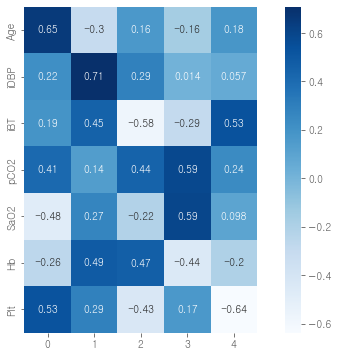

In [116]:
fig =plt.figure(figsize=(10,6))
ax = sns.heatmap(FacAnal_res,
                 cmap='Blues',# cmap Color
                 annot=True,            # Value Text
                 square=True,
                )

1. 요인 0 : 모두 높은 요인 적재량을 가진다. (Hb, SaO2) 와 나머지 변수의 차이로 계산 된다.

2. 요인 1 : 모두 높은 요인 적재량을 가지고 Age와 나머지 변수의 차로 계산된다.

3. 요인 2 : (Age, iDBP, pCO2, Hb) 와 (iBT,SaO2,Plt)의 차로 계산된다.

4. 요인 3 : iDBP가 낮은 적재량을 가진다. (Age,iBT,Hb) 와 (iDBP,pCO2,SaO2)의 차로 계산된다.

5. 요인 4 : iDBP,SaO2가 낮은 적재량을 가진다. (Plt,Hb)과 그 외의 차로 계산된다.


발생한 5 변수를 새로운 feature로써 분류에 사용할 예정.

# 범주형 자료 MCA

다중상응분석이란 3개 이상 다변량 범주형 변수의 복합적인 교차빈도분할표를 이용해서 분석하는 방법을 말한다.

## 모든 자료 MCA

In [117]:
#!pip install prince

In [118]:
train_category = x_train.select_dtypes(include='category')
mca = prince.MCA(n_components=2).fit(train_category)
mca.column_coordinates(train_category)

,0,1
sex_0,-0.193671,-0.029472
sex_1,0.502800,0.076515
mc_0,-0.279080,-0.184986
mc_1,0.948873,0.628951
Qsofa_0,-0.447698,-0.179701
Qsofa_1,0.295220,-0.176055
Qsofa_2,0.778094,0.585173
Qsofa_3,0.699942,1.313417
bed_0,-0.645674,-0.299945
bed_1,0.882693,0.410052


Text(0.5, 1.0, '상응분석')

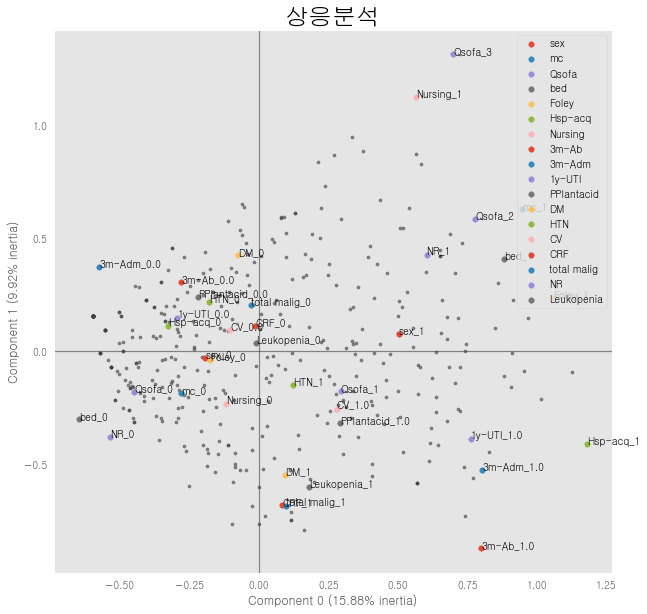

In [119]:
# 폰트 세팅
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
# 시각화
ax = mca.plot_coordinates(X = train_category, figsize=(10, 10), show_column_labels=True)
ax.set_title("상응분석", fontsize = 24)

이 그림에서 유의할점은 2차원 축소를 하여, 26%밖에 설명할 수 없다는 것이다.

사분면 별로 분석해보면,

- (1사분면) 침상 환자o, 신부전증 환자, Qsofa 2점 이상, 간호 o , Foley 1 사용, 의식변화, 여성이 동시에 발생한다. (내성으로 생각)

- (4사분면) 2일 이상 입원(HSP-acq1) ,  최근 3달 내 입원 (3m-Adm) ,최근 3달내 항생제 복용(3m-Ab), Qsofa 1점, 심장질환 o (CV) , 만성신부전 (CRF),  고혈압 (HTN) , 당뇨병 , 악성 종양, 백혈구 감소증 

- (3사분면) 침상 환자x, 신부전증이 없고, Qsofa 0점, 간호 x , Foley 0(도뇨관 종류), sex_0(남성?) 가 동시에 발생한다. (이 값들일 때 감수성이 있을것으로 생각된다.)


- (2사분면) 4사분면의 반대되는 값.


1,4 사분면이 CIP 내성을 , 2,3 사분면이 감수성을 나타내는 변수들이 매우 연관있음을 볼 수 있다.

알려진 가설대로 침상환자, 간호 여부, 최근 입원 여부가 큰 결정요소로 보인다.

성인병 여부들은 경계에 위치하여 약간의 기여도가 있음으로 보인다.


---


현재 범주형 변수들은 데이터 조작이 안되기에, 그대로 feature로 사용할 것으로 보인다.

또는 성인병 여부들은 제거해도 될것으로 보인다.

##  유의한 변수들 MCA

In [120]:
x_trained_reduced = x_train[['sex','mc','bed','Foley','Nursing','Hsp-acq',
                             '3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].copy() 

In [121]:
train_category = x_trained_reduced.select_dtypes(include='category')
mca = prince.MCA(n_components=2).fit(train_category)
mca.column_coordinates(train_category)

,0,1
sex_0,-0.192099,-0.062774
sex_1,0.498717,0.162972
mc_0,-0.225511,-0.123814
mc_1,0.766738,0.420969
bed_0,-0.658563,-0.346868
bed_1,0.900314,0.474199
Foley_0,-0.182447,-0.056046
Foley_1,1.105009,0.339448
Nursing_0,-0.112523,-0.305495
Nursing_1,0.545032,1.479741


Text(0.5, 1.0, 'reduced feature 상응분석')

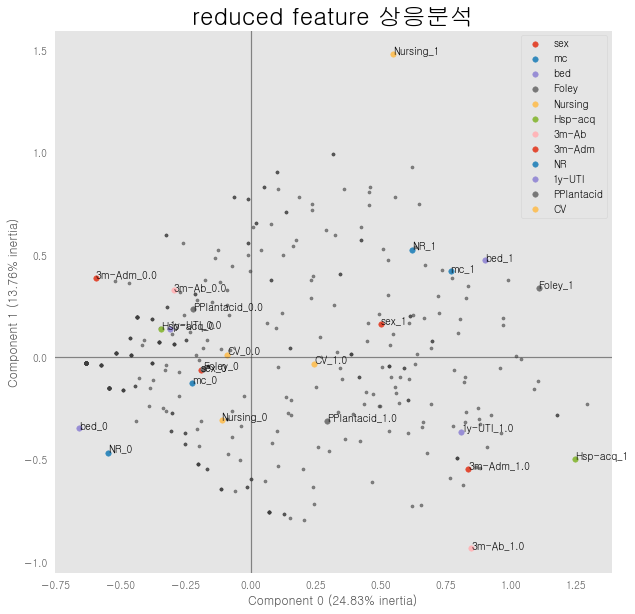

In [122]:
# 폰트 세팅
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
# 시각화
ax = mca.plot_coordinates(X = train_category, figsize=(10, 10), show_column_labels=True)
ax.set_title("reduced feature 상응분석", fontsize = 24)

침상, 입원 , neurodegenerative disease , Foley가 서로 연관되어있음을 볼 수 있다.

하지만, 이전 자료에서 Qsofa 가 유의한 것으로 관측되었는데 제외되어서 확인해본다. 

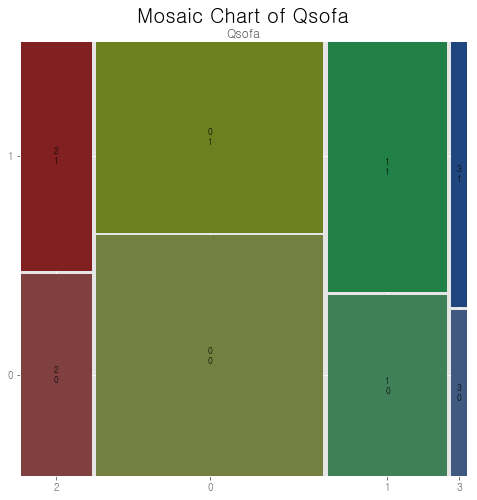

In [123]:
#Qsofa 조사

plt.rcParams["figure.figsize"]=(8,8)

mosaic(pd.concat([x_train['Qsofa'],y_train],axis=1),['Qsofa','CIP'],gap=0.01,label_rotation=True)


plt.title('Mosaic Chart of Qsofa', fontsize=20)

plt.xlabel('Qsofa')
plt.ylabel('CIP')

plt.show()
plt.rcParams["figure.figsize"]=(6.0,4.0)

Qsofa가 2,3 level이 서로 연관되어있음을 관측 할 수 있다.

따라서 grouping 후, 다시 검정을 실시한다.


In [124]:
#workclass grouping 

qsofa_group1 = [2,3]

x_train['Qsofa']=x_train['Qsofa'].replace(qsofa_group1, 2)


In [125]:
feat_crosstab=pd.crosstab(x_train['Qsofa'],y_train)
feat_crosstab_res=chi2_contingency(feat_crosstab)
print('Chi2 Statistic: {}, p-value: {}'.format(feat_crosstab_res[0], feat_crosstab_res[1]))
print('기각.')

Chi2 Statistic: 5.918020380179538, p-value: 0.05187023344296761
기각.


Qsofa는 grouping을 해도 기각하기는 어렵다. 이 정도의 차이는 샘플이 더 있어야 판단이 가능하다,

## 데이터셋 출력

In [127]:
#데이터셋 정리.
x_trained_reduced = x_train[['Age','iDBP','iBT','pCO2','SaO2','Hb','Plt']].copy() 

factor_trained = x_trained_reduced @ FacAnal_res
factor_trained.columns=['factor1','factor2','factor3','factor4','factor5']

x_trained_reduced_category=x_train[[ 'sex','mc','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].copy().astype('category')
x_trained_reduced_all=pd.concat([x_trained_reduced,
                                 factor_trained,
                                 x_trained_reduced_category],axis=1)
x_trained_reduced_all.head()



,Age,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,...,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
81,73,65,35.3,36.7,93.8,10.4,164,122.295414,123.535094,-58.961741,...,1,1,1,0,0.0,0.0,1,1.0,0.0,0.0
257,83,59,36.6,45.0,96.6,7.7,285,194.233941,152.900370,-109.810399,...,1,0,1,0,0.0,0.0,1,1.0,0.0,0.0
221,65,95,39.6,28.1,96.0,12.2,254,166.709039,175.756053,-96.071056,...,0,0,0,0,0.0,0.0,1,0.0,0.0,0.0
21,69,77,36.9,29.0,97.3,10.5,90,78.771191,112.216645,-29.503582,...,0,0,0,0,1.0,1.0,0,0.0,1.0,0.0
170,57,79,39.1,31.3,92.8,11.5,298,184.089604,178.698255,-118.784151,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0


In [129]:
#TEST 데이터셋 정리.
x_test_reduced = x_test[['Age','iDBP','iBT','pCO2','SaO2','Hb','Plt']].copy() 

x_test_reduced_category=x_test[[ 'sex','mc','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].copy().astype('category')
factor_test = x_test_reduced @ FacAnal_res
factor_test.columns=['factor1','factor2','factor3','factor4','factor5']

x_test_reduced_all=pd.concat([x_test_reduced,
                              factor_test,  
                              x_test_reduced_category,
                                 ],axis=1)
x_test_reduced_all.head()



,Age,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,...,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
253,78,58,39.1,30.8,94.7,13.1,191,135.413255,127.450813,-75.483074,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
317,74,82,39.4,40.4,93.2,14.0,194,144.099782,148.004641,-65.644781,...,0,0,0,0,1.0,1.0,0,0.0,1.0,0.0
235,79,69,38.2,34.2,94.5,13.4,236,163.391945,148.276442,-89.193911,...,0,0,0,0,0.0,0.0,0,0.0,0.0,1.0
439,94,50,38.6,33.5,91.9,12.1,152,126.239077,104.500246,-56.849264,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
220,83,68,39.4,32.6,94.7,11.5,129,109.447652,114.493339,-45.337301,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0


In [130]:
x_trained_reduced_all.to_excel("../data/cip_clean.xlsx",index=False)
x_test_reduced_all.to_excel("../data/cip_clean_test.xlsx",index=False)

In [131]:
y_train.to_excel("../data/cip_clean_y.xlsx",index=False)

In [132]:
y_test.to_excel("../data/cip_clean_test_y.xlsx",index=False)

# EDA를 통한 결론

Train 데이터 수가 작기에, 유의미한 feature를 활용하는 것이 필요하다.

다변량 자료에서 유의미한 Feature들을 추출하고, PCA와 MCA를 통해서 분포를 비교할 수 있었다.

결과적으로, 수치형 변수들은 분류에 큰 도움을 주지 못한다. 추출된 feature들만 활용했을때 pca 결과와 모든 변수를 활용했을 때 pca 결과가 유사하니, 유의미한 feature들만 사용해도 옳다고 생각된다. 하지만, PCA를 이용한 feature는 사용 못할 것으로 보인다.

또한. 수치형과 범주형 자료 모두 pca를 적용한 것도 유의하지 못했다.

대신 Factor analysis를 통해 얻은, 공통 변수를 활용해서 추가 변수로 활용한다.


범주형 자료들도 따로 변환없이 사용이 된다.

아쉽게도 기각을 못한 자료들은 샘플을 더 받아야지 알 수 있다.


- 유의미한 feature
    - 범주형 : sex,mc,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
    - 수치형 : Age,iDBP,iBT,pCO2,SaO2,Hb,Plt

